In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
get_ipython().run_line_magic('matplotlib', 'inline')

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

Reading data. Turning JAVA objects into dataframe's columns.

** Caveat: Here I consut a small part of code of SRK user on Kaggle to read the file. I think this is not a big significant part of the homework, and I think that this is the only way to read JSON object. Website: https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue

In [2]:
# Read Data
def load_df(csv_path, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

train_df = load_df("../input/ga-customer-revenue-prediction/train.csv")
test_df = load_df("../input/ga-customer-revenue-prediction/test.csv")

# train_df = pd.read_csv('../input/train_processed.csv')
# test_df = pd.read_csv('../input/test_processed.csv')

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)


**Question 1:**
Preprocessing data. Including following steps:
    - Omitting columns that have constant values across all samples
    - Filling NaN in "totals.transactionRevenue" column
    - Processing timestamp data from POSIX format to date-time format. And then compute useful features from them.
    - Turning category features to numbers by factorizing them. (this step will be introduced more in details below)
    

In [3]:
# In[]
# Preprocessing

# Replacing NaN values with 0
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].fillna(0)
train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].astype(float)

# Omitting columns having constant values
constant_cols = []
for c in train_df.columns:
    if train_df[c].nunique(dropna=False)==1:
        np.append(constant_cols,c)
constant_cols
for c in constant_cols:
    train_df = train_df.drop([c], axis = 1)
    test_df = test_df.drop([c], axis = 1)

# Read date and timestamp data
train_df['date_translated'] = train_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
train_df['visitStartTime_translated'] = [datetime.datetime.fromtimestamp(t) for t in train_df['visitStartTime'] ]
test_df['date_translated'] = test_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
test_df['visitStartTime_translated'] = [datetime.datetime.fromtimestamp(t) for t in test_df['visitStartTime'] ]

# Getting more information from date-time data
train_df['visit_month'] = train_df['visitStartTime_translated'].dt.month
train_df['visit_hour'] = train_df['visitStartTime_translated'].dt.hour
test_df['visit_month'] = test_df['visitStartTime_translated'].dt.month
test_df['visit_hour'] = test_df['visitStartTime_translated'].dt.hour



**Question 2:**

a) Generating heatmap of the session "Visiting Time" (in terms of month and hour) and "Transaction Revenue":

We find that there are a great correlation in the visit time and the revenue in terms of hour. Most of the revenue are created in the afternoon to midnight.This is quite easy to understand, since nobody visit GStore in the middle of the night (1am - 5am), and also, in the morning since they have to go to work.

In terms of month, we find there are a great demand in December, which must be because of Christmas. Indeed, at this time of the year, people still buy from GStore up to 2-3am in the morning.


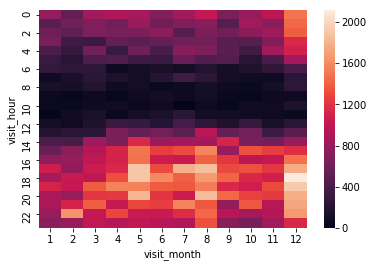

In [4]:
# Heatmap
train_df['visit_month'] = train_df['visitStartTime_translated'].dt.month
train_df['visit_hour'] = train_df['visitStartTime_translated'].dt.hour
train_df['totals.transactionRevenue_log'] = np.log1p(train_df['totals.transactionRevenue'].astype(float))
pivot_table = train_df.pivot_table('totals.transactionRevenue_log', index='visit_hour', columns='visit_month', aggfunc=np.sum)
ax = sns.heatmap(pivot_table)

We cluster data under many category (browser, device category, OS system,...) to see how these information affect the buying decision of customers.

** Caveat: The idea of clustering these variables come from the idea of user SRK on Kaggle. This is a very interesting idea and insights. Therefore, I use this idea. I did consult a small part of his code to derive my own implementation. 


In [5]:
# Defining function for plotting
def horizontal_bar_chart(df):
    bar_chart = go.Bar(
        y=df.index[::-1],
        x=df.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color='green',
        ),        
    )
    # bar_chart.set_yticklabels(df.index)   
    return bar_chart

# Clustering data
train_df['transactionRevenue_non_zero'] = train_df['totals.transactionRevenue']>0
# Cluster by devices
# browser
cluster_info = train_df.groupby('device.browser').agg({'transactionRevenue_non_zero':'sum', 'totals.transactionRevenue':['mean']})
cluster_info.columns = ["count of non-zero revenue", "average"]
cluster_info = cluster_info.sort_values(by="count of non-zero revenue", ascending=False)
bar_chart_browser_count = horizontal_bar_chart(cluster_info["count of non-zero revenue"].head(10))
bar_chart_browser_mean = horizontal_bar_chart(cluster_info["average"].head(10))
# deviceCategory
cluster_info = train_df.groupby('device.deviceCategory').agg({'transactionRevenue_non_zero':'sum', 'totals.transactionRevenue':['mean']})
cluster_info.columns = ["count of non-zero revenue", "average"]
cluster_info = cluster_info.sort_values(by="count of non-zero revenue", ascending=False)
bar_chart_deviceCategory_count = horizontal_bar_chart(cluster_info["count of non-zero revenue"].head(10))
bar_chart_deviceCategory_mean = horizontal_bar_chart(cluster_info["average"].head(10))
# operatingSystem
cluster_info = train_df.groupby('device.operatingSystem').agg({'transactionRevenue_non_zero':'sum', 'totals.transactionRevenue':['mean']})
cluster_info.columns = ["count of non-zero revenue", "average"]
cluster_info = cluster_info.sort_values(by="count of non-zero revenue", ascending=False)
bar_chart_operatingSystem_count = horizontal_bar_chart(cluster_info["count of non-zero revenue"].head(10))
bar_chart_operatingSystem_mean = horizontal_bar_chart(cluster_info["average"].head(10))



figure = tools.make_subplots(rows=3, cols=2, vertical_spacing=0.1, 
                                         subplot_titles=["Device Browser - Count of Non-zero Revenue Transaction", "Device Browser - Average Revenue",
                                          "Device Category - Count of Non-zero Revenue Transaction", "Device Category - Average Revenue", 
                                          "Device OS - Count of Non-zero Revenue Transaction", "Device OS - Average Revenue"])
figure.append_trace(bar_chart_browser_count, 1, 1)
figure.append_trace(bar_chart_browser_mean, 1, 2)
figure.append_trace(bar_chart_deviceCategory_count, 2, 1)
figure.append_trace(bar_chart_deviceCategory_mean, 2, 2)
figure.append_trace(bar_chart_operatingSystem_count, 3, 1)
figure.append_trace(bar_chart_operatingSystem_mean, 3, 2)
figure['layout'].update(height=1000, width=1400, paper_bgcolor='rgb(233,233,233)', title="Device Statistics")
py.iplot(figure, filename='device-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]



Clustering under customers' behavior


In [6]:
# Cluster by customers' behavior
# pageviews
cluster_info = train_df.groupby('totals.pageviews').agg({'transactionRevenue_non_zero':'sum', 'totals.transactionRevenue':['mean']})
cluster_info.columns = ["count of non-zero revenue", "average"]
cluster_info = cluster_info.sort_values(by="count of non-zero revenue", ascending=False)
bar_chart_pageviews_count = horizontal_bar_chart(cluster_info["count of non-zero revenue"].head(100))
bar_chart_pageviews_mean = horizontal_bar_chart(cluster_info["average"].head(100))
# hits
cluster_info = train_df.groupby('totals.hits').agg({'transactionRevenue_non_zero':'sum', 'totals.transactionRevenue':['mean']})
cluster_info.columns = ["count of non-zero revenue", "average"]
cluster_info = cluster_info.sort_values(by="count of non-zero revenue", ascending=False)
bar_chart_hits_count = horizontal_bar_chart(cluster_info["count of non-zero revenue"].head(100))
bar_chart_hits_mean = horizontal_bar_chart(cluster_info["average"].head(100))
figure = tools.make_subplots(rows=2, cols=2, vertical_spacing=0.1, 
                                         subplot_titles=["Page Views - Count of Non-zero Revenue Transaction", "Page Views - Average Revenue",
                                          "Hits - Count of Non-zero Revenue Transaction", "Hits - Average Revenue"])
figure.append_trace(bar_chart_pageviews_count, 1, 1)
figure.append_trace(bar_chart_pageviews_mean, 1, 2)
figure.append_trace(bar_chart_hits_count, 2, 1)
figure.append_trace(bar_chart_hits_mean, 2, 2)
figure['layout'].update(height=800, width=1400, paper_bgcolor='rgb(233,233,233)', title="Visitor Behavior Plots")
py.iplot(figure, filename='behavior-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



**Question 3: **

Clustering under geography

In [7]:
# Defining function for plotting
# Clustering data
train_df['transactionRevenue_non_zero'] = train_df['totals.transactionRevenue']>0
# Cluster by geography
# continent
cluster_info = train_df.groupby('geoNetwork.continent').agg({'transactionRevenue_non_zero':'sum', 'totals.transactionRevenue':['mean']})
cluster_info.columns = ["count of non-zero revenue", "average"]
cluster_info = cluster_info.sort_values(by="count of non-zero revenue", ascending=False)
bar_chart_continent_count = horizontal_bar_chart(cluster_info["count of non-zero revenue"].head(10))
bar_chart_continent_mean = horizontal_bar_chart(cluster_info["average"].head(10))
# subcontinent
cluster_info = train_df.groupby('geoNetwork.subContinent').agg({'transactionRevenue_non_zero':'sum', 'totals.transactionRevenue':['mean']})
cluster_info.columns = ["count of non-zero revenue", "average"]
cluster_info = cluster_info.sort_values(by="count of non-zero revenue", ascending=False)
bar_chart_subcontinent_count = horizontal_bar_chart(cluster_info["count of non-zero revenue"].head(10))
bar_chart_subcontinent_mean = horizontal_bar_chart(cluster_info["average"].head(10))
# country
cluster_info = train_df.groupby('geoNetwork.country').agg({'transactionRevenue_non_zero':'sum', 'totals.transactionRevenue':['mean']})
cluster_info.columns = ["count of non-zero revenue", "average"]
cluster_info = cluster_info.sort_values(by="count of non-zero revenue", ascending=False)
bar_chart_country_count = horizontal_bar_chart(cluster_info["count of non-zero revenue"].head(10))
bar_chart_country_mean = horizontal_bar_chart(cluster_info["average"].head(10))
# city
cluster_info = train_df.groupby('geoNetwork.city').agg({'transactionRevenue_non_zero':'sum', 'totals.transactionRevenue':['mean']})
cluster_info.columns = ["count of non-zero revenue", "average"]
cluster_info = cluster_info.sort_values(by="count of non-zero revenue", ascending=False)
bar_chart_city_count = horizontal_bar_chart(cluster_info["count of non-zero revenue"].head(10))
bar_chart_city_mean = horizontal_bar_chart(cluster_info["average"].head(10))


figure = tools.make_subplots(rows=4, cols=2, vertical_spacing=0.1, 
                                         subplot_titles=["Continent - Count of Non-zero Revenue Transaction", "Continent - Average Revenue",
                                          "Subcotinent - Count of Non-zero Revenue Transaction", "Subcotinent - Average Revenue", 
                                          "Country - Count of Non-zero Revenue Transaction", "Country - Average Revenue",
                                          "City - Count of Non-zero Revenue Transaction", "City - Average Revenue"])
figure.append_trace(bar_chart_continent_count, 1, 1)
figure.append_trace(bar_chart_continent_mean, 1, 2)
figure.append_trace(bar_chart_subcontinent_count, 2, 1)
figure.append_trace(bar_chart_subcontinent_mean, 2, 2)
figure.append_trace(bar_chart_country_count, 3, 1)
figure.append_trace(bar_chart_country_mean, 3, 2)
figure.append_trace(bar_chart_city_count, 4, 1)
figure.append_trace(bar_chart_city_mean, 4, 2)
figure['layout'].update(height=1400, width=1400, paper_bgcolor='rgb(233,233,233)', title="Geography Statistics")
py.iplot(figure, filename='geography-plots')



This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]
[ (4,1) x7,y7 ]  [ (4,2) x8,y8 ]



**Question 5:**

For extending dataset, we use two dataset that we think might affect the customer's behaviors in GStore, they are:

1) The stock market performance of GStore:
A company's stock price reflects its performance as well as opinions of customers/investors about it and therefore, might reflect their intention to buy products from the company. For example, if the new released product is a good product, having many good review from critics and journalists, then the price of the stock will rise, and customers also would like to buy new products, too. In contrast, if there is something wrong with the new product, the stock price will drop and customers would not like to buy it. For example, when the Samsung Galaxy Note 7 is announced to be very dangerous, the Samsung stock price decrease drastically, the customers also postponed their decision to buy that product.

2) The price of USD overtime:
For countries in Asia, such as Vietnam (my country), we do care allot about this exhange rates, since it greatly affects the price of the product. Indeed, many of the products on GStore are sold in USD, and we then multiply them with the exchange rate (USD->VND) to have the amount of VND we have to pay. Many times, if the USD is strong, the exchange rate will be high, and therefore we have to pay more. Many times we consider buying or not because of this. 


In [8]:
# Augmented dataset 1 - Google Stock price
GOO_stock = pd.read_csv("../input/google-stock-price/GOO_stock.csv", skipinitialspace=True)
GOO_stock.date = pd.to_datetime(GOO_stock.date).dt.date
GOO_stock_dict = GOO_stock.set_index('date')['close'].to_dict()
train_df['GOO_stock'] = pd.to_datetime(train_df['visitStartTime_translated'].dt.date).map(GOO_stock_dict)
train_df['GOO_stock'] = train_df['GOO_stock'].convert_objects(convert_numeric=True)
train_df.loc[train_df['GOO_stock'].isnull(),'GOO_stock'] = 0
test_df['GOO_stock'] = pd.to_datetime(test_df['visitStartTime_translated'].dt.date).map(GOO_stock_dict)
test_df['GOO_stock'] = test_df['GOO_stock'].convert_objects(convert_numeric=True)
test_df.loc[test_df['GOO_stock'].isnull(),'GOO_stock'] = 0

# Augmented dataset 2 - USD price
usd_to_eur = pd.read_csv("../input/google-stock-price/usd_to_eur.csv", skipinitialspace=True)
usd_to_eur_dict = usd_to_eur.set_index('DATE')['DEXUSEU'].to_dict()
train_df['usd_to_eur'] = train_df['visitStartTime_translated'].dt.date.astype(str).map(usd_to_eur_dict)
train_df['usd_to_eur'] = train_df['usd_to_eur'].convert_objects(convert_numeric=True)
train_df.loc[train_df['usd_to_eur'].isnull(),'usd_to_eur'] = 0
test_df['usd_to_eur'] = test_df['visitStartTime_translated'].dt.date.astype(str).map(usd_to_eur_dict)
test_df['usd_to_eur'] = test_df['usd_to_eur'].convert_objects(convert_numeric=True)
test_df.loc[test_df['usd_to_eur'].isnull(),'usd_to_eur'] = 0

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning:

convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning:

convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning:

convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning:

convert_objects is de

**Question 4:**

Processing category data for training and testing models:
    - Turning category features to numbers by factorizing them. For category each feature, I sort the feature in terms of number of true buyers (having positive revenue). Then assign 1 for the value having lowest number of buyers and assign N (the number of unique values of that category features) for the one having highest number of buyers. Other values are assigned to be the order of them in the sort respectively. This is to utilize the category information. If we just assign them randomly, we will accidentally introduce an "meaningless order" to the values and therefore, might affect badly the model.

In [9]:
# Back-up data
train_df0 = train_df.copy()
test_df0 = test_df.copy()
# train_df = train_df0.copy()
# test_df = test_df0.copy()

# Turn category variables to numbers
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", 
            ]
train_df_positive_revenue = train_df[train_df['totals.transactionRevenue']>0]
train_df_temp = train_df.copy()
test_df_temp = test_df.copy()
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    group_by_col_counts = train_df_positive_revenue.groupby(col).agg({col:'count'}).rename(columns={col:'counts'})
    sorted_10_group_by_col_counts = group_by_col_counts.sort_values(by=['counts'], ascending=False)[0:max(10,group_by_col_counts.shape[0])]
    sorted_10_index_list = sorted_10_group_by_col_counts.index
    train_df_temp.loc[-train_df_temp[col].isin(sorted_10_index_list), col] = "Non-significant"    
    test_df_temp.loc[-test_df_temp[col].isin(sorted_10_index_list), col] = "Non-significant"
    sorted_11_index_list = np.append(sorted_10_index_list, "Non-significant")
    lbl.fit(sorted_11_index_list)
    classes = lbl.classes_
    
    train_df_temp[col] = lbl.transform(list(train_df_temp[col].values.astype('str'))).astype(float)
    test_df_temp[col] = lbl.transform(list(test_df_temp[col].values.astype('str'))).astype(float)  
    for i in range(sorted_11_index_list.shape[0]):
        class_ith = list(classes).index(sorted_11_index_list[i])
        train_df.loc[train_df_temp[col].values == class_ith, col] = float(i)
        test_df.loc[test_df_temp[col].values == class_ith, col] = float(i)
        
        
# Turn numeric columns to float
num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visit_hour", "visit_month", 'usd_to_eur', 'GOO_stock']    
for col in num_cols:
    print(col)
    train_df[col] = train_df[col].astype(float)
    train_df[col] = train_df[col].fillna(train_df[col].mean())
    test_df[col] = test_df[col].astype(float)
    test_df[col] = test_df[col].fillna(test_df[col].mean())    
   
train_df.to_csv('train_processed.csv')
test_df.to_csv('test_processed.csv')

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
totals.hits
totals.pageviews
visitNumber
visit_hour
visit_month
usd_to_eur
GOO_stock


Defining a score. Here we use the logistic regression to compute the probability a user would buy in GStore.

In [10]:
# Cluster across unique users
cluster_info = train_df.groupby('fullVisitorId').agg('mean')
cluster_info['totals.transactionRevenue'] = train_df.groupby('fullVisitorId').agg({'totals.transactionRevenue':np.sum})
cluster_info['totals.pageviews'] = train_df.groupby('fullVisitorId').agg({'totals.pageviews':np.sum})
cluster_info['visitNumber'] = train_df.groupby('fullVisitorId').agg({'visitNumber': 'max'})
cluster_info['totals.hits'] = train_df.groupby('fullVisitorId').agg({'totals.hits':np.sum})
cluster_info['fullVisitorId'] = cluster_info.index

# Defining a function for scoring the probability a customer buying a product from Google store
from sklearn import linear_model
clf = linear_model.LogisticRegression()
features = ['visitNumber','totals.pageviews','visitNumber','totals.hits', 'visit_hour']
# features = cat_cols + num_cols
X = cluster_info[features]

# To have it fair, we train a same amount of negative and positive samples
X_positive = cluster_info[features][cluster_info['totals.transactionRevenue'] > 0]
num_positive = X_positive.shape[0]
num_negative = num_positive
X_negative = cluster_info[features][0:num_negative]
X_combined = X_positive.append(X_negative)
y_label = np.append(np.ones([num_positive,1]),np.zeros([num_negative,1]))
clf.fit(X_combined, y_label)
y_predicted = clf.predict_proba(X)
y_prediction = pd.DataFrame({'fullVisitorId': cluster_info['fullVisitorId'], 'totals.transactionRevenue' :y_predicted[:,1]})
y_prediction_sorted = y_prediction.sort_values(by=['totals.transactionRevenue'], ascending = False)
y_prediction_sorted[0:10]
cluster_info['totals.transactionRevenue'][y_prediction_sorted[0:10]['fullVisitorId']]



fullVisitorId
596895434219823695     4.509100e+08
1814166460229302850    7.042510e+09
213465488216513322     1.325570e+09
4921413806940784676    3.314300e+08
0092531753747954140    0.000000e+00
4278365513858458160    6.744000e+07
4086679804074527652    0.000000e+00
5341271361784611942    2.969540e+09
9771437221362506189    5.678900e+08
7638336411447332495    1.577490e+09
Name: totals.transactionRevenue, dtype: float64

**Questions 5:**

Building model for our regressor. The technique used is LightGBM. With tuned parameters.

** Caveat: Here I also consult SRK's model. I actually tried many models before this (Linear regression, Ridge regression, even neural network,...) but they either are not so accurate or taking too long to train (neural network). I find his model pretty effective and also very interesting. So I choose to apply it and have learned a lot about this new knowledge. However, there should be some differences between my model and his model in terms of features. I have explained above about the difference in  our features (more specifically the way we preprocess features).

In [11]:
def model(X_train, y_train, X_val, y_val):
    X_train = X_train.loc[:, X_train.columns != 'fullVisitorId']
    X_val = X_val.loc[:, X_val.columns != 'fullVisitorId']
    
    params = {
        "objective" : "regression", "metric" : "rmse", "num_leaves" : 30,"min_child_samples" : 95,"learning_rate" : 0.05,"bagging_fraction" : 0.7,"feature_fraction" : 0.5,"bagging_frequency" : 5,"bagging_seed" : 2000,"verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(X_train, label=y_train)
    lgval = lgb.Dataset(X_val, label=y_val)
    reg = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)

    return reg

Training and validating on available dataset.

In [12]:
# Building training data
model_features = ['fullVisitorId'] + cat_cols + num_cols 
X = train_df[model_features]
X_test = test_df[model_features]
y = train_df['totals.transactionRevenue'].astype(float)
y = np.log1p(y)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Training model
model = model(X_train, y_train, X_val, y_val)

# Validating 
X_val_nouserID = X_val.loc[:, X_val.columns != 'fullVisitorId']
y_val_prediction = np.expm1(model.predict(X_val_nouserID, num_iteration=model.best_iteration))
y_val_prediction[y_val_prediction<0] = 0
y_val_prediction_dataframe = pd.DataFrame({'fullVisitorId': X_val['fullVisitorId'], 'totals.transactionRevenue' :y_val_prediction})
y_val_prediction_user = np.log1p(y_val_prediction_dataframe.groupby('fullVisitorId').agg('sum'))
y_val = np.expm1(y_val)
y_val_dataframe = pd.DataFrame({'fullVisitorId': X_val['fullVisitorId'], 'totals.transactionRevenue' :y_val})
y_val_user = np.log1p(y_val_dataframe.groupby('fullVisitorId').agg('sum'))
np.sqrt(metrics.mean_squared_error(y_val_prediction_user, y_val_user))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.60434
[200]	valid_0's rmse: 1.59231
[300]	valid_0's rmse: 1.58521
[400]	valid_0's rmse: 1.58247
[500]	valid_0's rmse: 1.581
[600]	valid_0's rmse: 1.58092
Early stopping, best iteration is:
[544]	valid_0's rmse: 1.58067


1.5916751076544868

Testing and creating submission file.

In [14]:
X_test_nouserID = X_test.loc[:, X_test.columns != 'fullVisitorId']
y_test_prediction = np.expm1(model.predict(X_test_nouserID, num_iteration=model.best_iteration))
y_test_prediction[y_test_prediction<0] = 0
submission_df = pd.DataFrame({"fullVisitorId":X_test["fullVisitorId"], 'totals.transactionRevenue' :y_test_prediction})
submission_df = submission_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()
submission_df["totals.transactionRevenue"] = np.log1p(submission_df["totals.transactionRevenue"])
submission_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
submission_df.to_csv("baseline_lgb.csv", index=False)


**Question 6:**

Running permutation tests to measure importance of features.

In [ ]:
def permutation_test(X, y, testing_features):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    num_features = len(testing_features)
    num_samples = X_train.shape[0]
    p_values = np.zeros(num_features)
    for i in range(num_features):
        # Number of permutations per feature
        print(testing_features[i])
        N = 40
        rmse_losses = np.zeros(N)           
        
        for j in range(0,N):
            print(j)
            X_train_shuffle = X_train.copy();
            # For j=0, we will keep the original order as the true order
            indexes_array = np.array(range(0,num_samples))
            if (j>0):
                np.random.shuffle(indexes_array)
#            shuffle_values = X_train[testing_features[i]].iloc[indexes_array].values    
#            X_train_shuffle.assign(testing_features[i] = shuffle_values)    
            X_train_shuffle[testing_features[i]] = X_train_shuffle[testing_features[i]].iloc[indexes_array].values
#            print(X_train_shuffle[testing_features[i]].head(10))
#            print(X_train[testing_features[i]].head(10))
#            print(X_train[testing_features[i]].iloc[indexes_array].head(10))
            
            # Training and evaluating models            
            model_j = model(X_train_shuffle, y_train, X_val, y_val)
            X_val_nouserID = X_val.loc[:, X_val.columns != 'fullVisitorId']
            y_val_prediction = model_j.predict(X_val_nouserID, num_iteration=model_j.best_iteration)  
            rmse_loss = np.sqrt(metrics.mean_squared_error(y_val_prediction, y_val))
            rmse_losses[j] = rmse_loss
            print(rmse_loss)
            
            # If having right order, save the value
            if sum(indexes_array==np.array(range(0,num_samples))) == num_samples:
                true_order_rmse_loss = rmse_loss
        
        # Calculating p_value
        plt.hist(rmse_losses, bins = int(N*2))
        plt.axvline(true_order_rmse_loss, color='k', linestyle='dashed', linewidth=1)
        p_values[i] = sum(rmse_losses <= true_order_rmse_loss)/N
        plt.title(testing_features[i] + ", N = " + str(N) + ", p_value:" + str(p_values[i]))
        
    return p_values, rmse_losses, true_order_rmse_loss, N    

# Executing permutation test
testing_features = ["geoNetwork.city"]    
p_values, rmse_losses, true_order_rmse_loss, N = permutation_test(X, y, testing_features)

# Ploting histogram
plt.hist(rmse_losses, bins = int(N/3.5))
plt.axvline(true_order_rmse_loss, color='k', linestyle='dashed', linewidth=1)
plt.title(testing_features[0] + ", N = " + str(N) + ", p_value:" + str(p_values))
plt.ylabel('Frequency')
plt.xlabel('Loss')